In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel





In [2]:
model_name = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(model_name)

model = BertModel.from_pretrained(
    model_name,
    output_attentions=True
)

model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [3]:
sentence = "The mechanic inspected the engine because it was noisy."


In [4]:
inputs = tokenizer(sentence, return_tensors="pt")


In [5]:
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
tokens

['[CLS]',
 'the',
 'mechanic',
 'inspected',
 'the',
 'engine',
 'because',
 'it',
 'was',
 'noisy',
 '.',
 '[SEP]']

In [6]:
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions


In [7]:
layer = 0
head = 0

attention_matrix = attentions[layer][0, head].cpu().numpy()

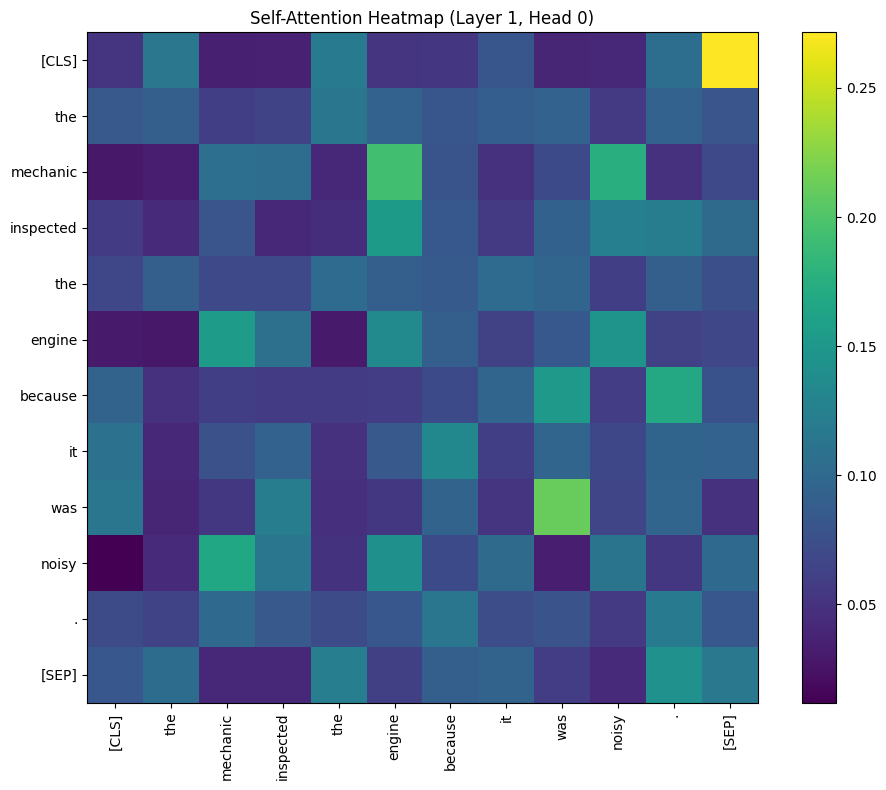

In [8]:
plt.figure(figsize=(10, 8))
plt.imshow(attention_matrix, cmap="viridis")

plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)

plt.colorbar()
plt.title("Self-Attention Heatmap (Layer 1, Head 0)")
plt.tight_layout()

plt.savefig("outputs/attention_heatmap.png")
plt.show()

A2 — Understand Positional Encoding

In [9]:
sentence_original = "The cat sat on the mat"
sentence_scrambled = "Mat the on sat cat the"


In [10]:
import torch.nn.functional as F

def get_sentence_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Last hidden state: (batch, seq_len, hidden_dim)
    token_embeddings = outputs.last_hidden_state

    # Mean pooling over tokens
    sentence_embedding = token_embeddings.mean(dim=1)

    return sentence_embedding


In [11]:
emb_original = get_sentence_embedding(sentence_original)
emb_scrambled = get_sentence_embedding(sentence_scrambled)

In [12]:
sentence_similarity = F.cosine_similarity(
    emb_original, emb_scrambled
)

sentence_similarity.item()

0.7193946838378906

In [13]:
def get_token_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state.squeeze(0)


In [14]:
tokens_original = get_token_embeddings(sentence_original)
tokens_scrambled = get_token_embeddings(sentence_scrambled)

token_level_similarity = F.cosine_similarity(
    tokens_original.mean(dim=0),
    tokens_scrambled.mean(dim=0),
    dim=0
)

token_level_similarity.item()

0.7193946838378906

A3 — Encoder vs Decoder Architecture

A3.1 — Encoder Task: Fill-Mask (BERT)

In [15]:
from transformers import pipeline

In [16]:
fill_mask = pipeline(
    "fill-mask",
    model="bert-base-uncased"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [17]:
text = "Transformers are [MASK] at understanding context."

In [18]:
results = fill_mask(text)

for r in results[:5]:
    print(f"{r['token_str']:>12}  |  score = {r['score']:.4f}")

        good  |  score = 0.4704
      better  |  score = 0.1913
        best  |  score = 0.0393
   excellent  |  score = 0.0335
   effective  |  score = 0.0315


A3.2 — Decoder Task: Text Generation (GPT-2)

In [19]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")

gpt_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [20]:
prompt = "Transformers are powerful because"

In [21]:
inputs = gpt_tokenizer(prompt, return_tensors="pt")

outputs = gpt_model.generate(
    **inputs,
    max_length=50,
    temperature=0.7,
    do_sample=True,
    num_return_sequences=3
)

for i, out in enumerate(outputs, 1):
    print(f"\nOutput {i}:")
    print(gpt_tokenizer.decode(out, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Output 1:
Transformers are powerful because they are able to be turned into a powerful force. The force can be turned into a small amount of power, but it is not enough to get the person to feel good. It may be that their own subconscious is trying

Output 2:
Transformers are powerful because they can do both at the same time.

"It takes more time to move around than it takes to move a ball," he said. "So it's really the same thing."

The team is planning

Output 3:
Transformers are powerful because they have the ability to regenerate health and armor at will.

The Aptitude Shield is a unique weapon which increases its damage by 40%. It has a base range of 4.5m and has a maximum damage


B — Tokens, Embeddings & Context Windows

B1) Tokenization Strategies: Word vs Subword

In [22]:
from transformers import BertTokenizer, GPT2Tokenizer

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [23]:
words = [
    "unbelievable",
    "internationalization",
    "electroencephalography",
    "bioinformatics",
    "mecahnical"   
]


In [24]:
import pandas as pd

rows = []

for word in words:
    bert_tokens = bert_tokenizer.tokenize(word)
    gpt2_tokens = gpt2_tokenizer.tokenize(word)

    rows.append({
        "Word": word,
        "BERT Tokens": bert_tokens,
        "BERT Token Count": len(bert_tokens),
        "GPT-2 Tokens": gpt2_tokens,
        "GPT-2 Token Count": len(gpt2_tokens),
    })

token_table = pd.DataFrame(rows)
token_table


,Word,BERT Tokens,BERT Token Count,GPT-2 Tokens,GPT-2 Token Count
0,unbelievable,[unbelievable],1,"[un, bel, iev, able]",4
1,internationalization,"[international, ##ization]",2,"[international, ization]",2
2,electroencephalography,"[electro, ##ence, ##pha, ##log, ##raphy]",5,"[elect, ro, ence, phal, ography]",5
3,bioinformatics,"[bio, ##in, ##form, ##atics]",4,"[b, io, in, format, ics]",5
4,mecahnical,"[me, ##ca, ##hn, ##ical]",4,"[m, ec, ahn, ical]",4


B2) Embeddings & Semantic Meaning

In [25]:
sentences = [
    # Aviation Maintenance
    "Aircraft engines require regular inspection",
    "Maintenance ensures flight safety",
    "Hydraulic systems control aircraft movement",

    # Finance
    "Stock markets fluctuate daily",
    "Investment strategies reduce risk",
    "Interest rates affect loans",

    # Health
    "Doctors diagnose diseases",
    "Exercise improves cardiovascular health",
    "Vaccines prevent infections",

    # Sports
    "Football requires teamwork",
    "Athletes train daily",
    "Championship matches attract fans"
]

In [26]:
def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)

    # Mean pooling over tokens
    embedding = outputs.last_hidden_state.mean(dim=1)

    return embedding.squeeze(0)


In [27]:
import torch

embeddings = torch.stack([get_embedding(s) for s in sentences])

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)

pd.DataFrame(similarity_matrix, index=sentences, columns=sentences)

,Aircraft engines require regular inspection,Maintenance ensures flight safety,Hydraulic systems control aircraft movement,Stock markets fluctuate daily,Investment strategies reduce risk,Interest rates affect loans,Doctors diagnose diseases,Exercise improves cardiovascular health,Vaccines prevent infections,Football requires teamwork,Athletes train daily,Championship matches attract fans
Aircraft engines require regular inspection,1.000000,0.769696,0.734905,0.460746,0.593513,0.586496,0.574927,0.554345,0.640285,0.620525,0.528779,0.595766
Maintenance ensures flight safety,0.769696,1.000000,0.753827,0.428511,0.615435,0.546690,0.512125,0.643230,0.574311,0.647274,0.546311,0.558464
Hydraulic systems control aircraft movement,0.734905,0.753827,1.000000,0.486775,0.583969,0.590652,0.586096,0.616238,0.579035,0.587881,0.558237,0.577891
Stock markets fluctuate daily,0.460746,0.428511,0.486775,1.000000,0.571025,0.638559,0.540796,0.529505,0.472270,0.404249,0.437634,0.500565
Investment strategies reduce risk,0.593513,0.615435,0.583969,0.571025,1.000000,0.760416,0.570724,0.637444,0.718067,0.598669,0.485487,0.575125
Interest rates affect loans,0.586496,0.546690,0.590652,0.638559,0.760416,1.000000,0.606251,0.619763,0.659156,0.528761,0.484297,0.559455
Doctors diagnose diseases,0.574927,0.512125,0.586096,0.540796,0.570724,0.606251,1.000000,0.627627,0.723650,0.492119,0.516218,0.565274
Exercise improves cardiovascular health,0.554345,0.643230,0.616238,0.529505,0.637444,0.619763,0.627627,1.000000,0.710534,0.572471,0.574434,0.596527
Vaccines prevent infections,0.640285,0.574311,0.579035,0.472270,0.718067,0.659156,0.723650,0.710534,1.000000,0.547560,0.537607,0.618301
Football requires teamwork,0.620525,0.647274,0.587881,0.404249,0.598669,0.528761,0.492119,0.572471,0.547560,1.000000,0.596697,0.631255


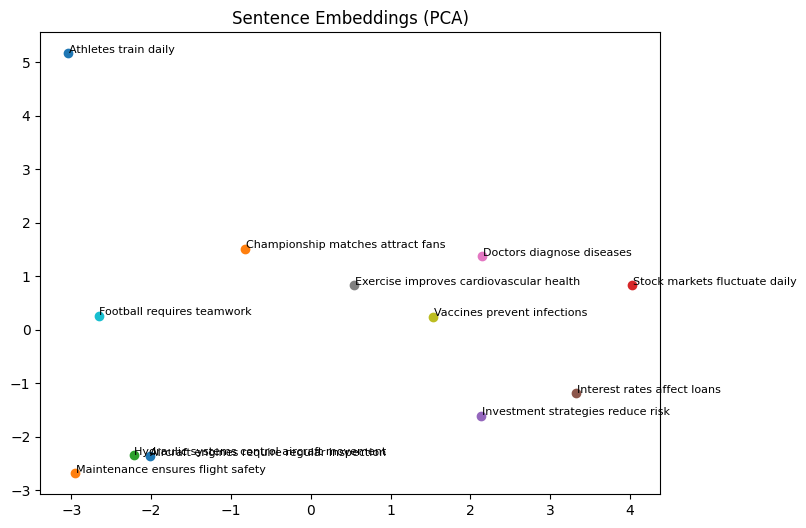

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))

for i, sentence in enumerate(sentences):
    plt.scatter(reduced[i, 0], reduced[i, 1])
    plt.text(reduced[i, 0] + 0.01, reduced[i, 1] + 0.01, sentence, fontsize=8)

plt.title("Sentence Embeddings (PCA)")
plt.show()

B3) Context Window Limits (Practical Experiment)

In [30]:
base_text = "This is a filler sentence. "
long_prompt = (
    "The secret key is ORANGE-9281. "
    + base_text * 800
)

In [31]:
question_prompt = long_prompt + "\nWhat is the secret key?"

inputs = gpt_tokenizer(
    question_prompt,
    return_tensors="pt",
    truncation=True,
    max_length=900   # explicit control
)

output = gpt_model.generate(
    **inputs,
    max_new_tokens=20,   # ✅ safer than max_length
    do_sample=False
)

print(gpt_tokenizer.decode(output[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The secret key is ORANGE-9281. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentence. This is a filler sentenc

C1) Pretraining Objectives

C1: Masked Language Modeling (BERT-style)

In [32]:
sentences = [
    "The aircraft engine requires regular inspection.",
    "Hydraulic systems can leak under high pressure.",
    "Routine maintenance improves flight safety.",
    "Avionics systems depend on reliable power supply.",
    "Corrosion can weaken structural components.",
    "Lubrication reduces friction in moving parts.",
    "Fuel systems must be checked for contamination.",
    "Sensors monitor engine performance continuously.",
    "Preventive maintenance reduces unexpected failures.",
    "Technicians follow strict safety procedures."
]

In [33]:
import random

def mask_sentence(sentence, mask_token="[MASK]", mask_prob=0.15):
    words = sentence.split()
    masked = []
    original = []

    for word in words:
        if random.random() < mask_prob:
            masked.append(mask_token)
            original.append(word)
        else:
            masked.append(word)
            original.append(word)

    return " ".join(masked), " ".join(original)

masked_data = [mask_sentence(s) for s in sentences]

for m, o in masked_data[:3]:
    print("Masked:  ", m)
    print("Original:", o)
    print()

Masked:   The aircraft engine [MASK] regular inspection.
Original: The aircraft engine requires regular inspection.

Masked:   Hydraulic systems can leak under high [MASK]
Original: Hydraulic systems can leak under high pressure.

Masked:   [MASK] [MASK] improves [MASK] safety.
Original: Routine maintenance improves flight safety.



In [44]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="bert-base-uncased"
)

correct = 0
total = 0

for masked, original in masked_data:
    if "[MASK]" not in masked:
        continue

     
    preds = fill_mask(masked)
    
    if isinstance(preds[0], list):
        top_prediction = preds[0][0]
    else:
        top_prediction = preds[0]
    prediction = top_prediction["token_str"]
    true_word = original.split()[masked.split().index("[MASK]")]

    print(f"Masked:    {masked}")
    print(f"Predicted: {prediction}")
    print(f"True:      {true_word}")
    print("-" * 40)

    total += 1
    if prediction.lower() == true_word.lower():
        correct += 1

print(f"\nTop-1 Accuracy: {correct}/{total} = {correct/total:.2f}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Masked:    The aircraft engine [MASK] regular inspection.
Predicted: requires
True:      requires
----------------------------------------
Masked:    Hydraulic systems can leak under high [MASK]
Predicted: .
True:      pressure.
----------------------------------------
Masked:    [MASK] [MASK] improves [MASK] safety.
Predicted: this
True:      Routine
----------------------------------------
Masked:    [MASK] reduces friction in moving parts.
Predicted: this
True:      Lubrication
----------------------------------------
Masked:    [MASK] systems must be checked for contamination.
Predicted: the
True:      Fuel
----------------------------------------
Masked:    Sensors [MASK] [MASK] performance [MASK]
Predicted: for
True:      monitor
----------------------------------------

Top-1 Accuracy: 1/6 = 0.17


C2) Fine-Tuning vs Instruction Tuning

In [45]:
from transformers import pipeline

base_model = pipeline(
    "text-generation",
    model="gpt2"
)

instruction_model = pipeline(
    "text2text-generation",
    model="google/flan-t5-small"
)


Device set to use cpu


config.json: 0.00B [00:00, ?B/s]

c:\Users\yibes\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yibes\.cache\huggingface\hub\models--google--flan-t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [46]:
instructions = [
    "Summarize this in one sentence: Transformers enable parallel attention.",
    "Convert this text to JSON: name=engine, status=operational",
    "Classify sentiment as positive or negative: I love working with transformers."
]


In [47]:
for instr in instructions:
    print("\nINSTRUCTION:", instr)

    print("\nBase GPT-2 output:")
    print(
        base_model(
            instr,
            max_new_tokens=40
        )[0]["generated_text"]
    )

    print("\nInstruction-Tuned FLAN-T5 output:")
    print(
        instruction_model(
            instr
        )[0]["generated_text"]
    )

    print("-" * 60)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



INSTRUCTION: Summarize this in one sentence: Transformers enable parallel attention.

Base GPT-2 output:
Summarize this in one sentence: Transformers enable parallel attention. (You know, like the ones seen in the original film, where you could make a whole bunch of lists on a whim, just to get that list of Transformers to go with the one that was

Instruction-Tuned FLAN-T5 output:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers enable parallel attention.
------------------------------------------------------------

INSTRUCTION: Convert this text to JSON: name=engine, status=operational

Base GPT-2 output:
Convert this text to JSON: name=engine, status=operational, message=Engine.Diagnostics.Logging.LoggingError Message=Engine.Diagnostics.LoggingError ErrorMessage=Engine.Diagnostics.LoggingError Message=

Instruction-Tuned FLAN-T5 output:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


name = engine, status = operational
------------------------------------------------------------

INSTRUCTION: Classify sentiment as positive or negative: I love working with transformers.

Base GPT-2 output:
Classify sentiment as positive or negative: I love working with transformers. I like how they use sound to bring people together, and I like how they can help people with their struggles.

Take the word "love" from your vocabulary. Love is the ability to

Instruction-Tuned FLAN-T5 output:
positive
------------------------------------------------------------


C3 — RLHF (Reinforcement Learning from Human Feedback) — Preference Optimization

In [48]:
prompts = [
    "Write a polite email declining a meeting.",
    "Give a safe answer to a risky question.",
    "Explain artificial intelligence to a non-technical audience."
]


In [49]:
def generate_response(prompt, temperature):
    inputs = gpt_tokenizer(prompt, return_tensors="pt")

    output = gpt_model.generate(
        **inputs,
        max_new_tokens=80,
        temperature=temperature,
        do_sample=True
    )

    return gpt_tokenizer.decode(output[0], skip_special_tokens=True)

In [50]:
for prompt in prompts:
    print("\nPROMPT:", prompt)

    response_A = generate_response(prompt, temperature=0.2)
    response_B = generate_response(prompt, temperature=0.9)

    print("\nCandidate A (safer):")
    print(response_A)

    print("\nCandidate B (creative):")
    print(response_B)

    print("-" * 70)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



PROMPT: Write a polite email declining a meeting.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Candidate A (safer):
Write a polite email declining a meeting.

"I'm not going to be a part of this," she said. "I'm not going to be a part of this."

She said she's not sure what she'll do next.

"I'm not going to be a part of this," she said. "I'm not going to be a part of this."

The woman said she's not

Candidate B (creative):
Write a polite email declining a meeting.

"The only person I am talking about is you," he said, according to a transcript of our conversation.

"You are not the only person who does this," he continued.

I asked him if he knows a real name. He just doesn't seem to know anything about it.

I said I haven't seen him in person and he seemed to think I
----------------------------------------------------------------------

PROMPT: Give a safe answer to a risky question.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Candidate A (safer):
Give a safe answer to a risky question.

"I think it's important to understand that the question is not about whether you're going to be able to do something in the future," he said. "It's about whether you're going to be able to do something in the future."

The question is whether the government will be able to do it.

"I think it's important to understand that the question is

Candidate B (creative):
Give a safe answer to a risky question.

Ask a more professional question, one with more authority.

Ask for help in a more professional manner.

If you answer correctly, you're a master of this!

What if I'm doing something wrong?

When we were first in high school, a lot of teachers had a problem with reading comprehension in students so we gave them time off to read.

----------------------------------------------------------------------

PROMPT: Explain artificial intelligence to a non-technical audience.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Candidate A (safer):
Explain artificial intelligence to a non-technical audience.

The following is an excerpt from the book, "The Machine: A Practical Guide to Artificial Intelligence," by David H. Hirsch, PhD, and published by the MIT Press.

The Machine: A Practical Guide to Artificial Intelligence

In the book, Hirsch describes how to use artificial intelligence to solve problems in a non-technical way. He describes how to use

Candidate B (creative):
Explain artificial intelligence to a non-technical audience. The goal of this article is to describe what artificial intelligence is, how it is working, and how that is useful to the non-technical audience.

What Does Aint Aint?

An artificial intelligence is a program that takes information from information sources and processes it to make useful and accurate decisions about information. An AI program is typically understood as a computer program, but as such it
----------------------------------------------------------------------


RLHF trains language models using human preference rankings rather than explicit labels. Multiple candidate responses are generated for the same prompt, humans select the preferred output, and a reward model learns to score responses accordingly. Reinforcement learning then optimizes the policy to favor outputs aligned with human preferences, improving safety and usefulness.